In [1]:
import torch
import torchvision
import os, time, tqdm
from models.cvae import loss, cVAE
from utils import EarlyStop
from datasets import celeba
from matplotlib import pyplot as plt
from datasets.inpainting import DeleteRandomRectangle, DeleteRectangle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def crop(x, low, high):
    x[x <= low] = low
    x[x >= high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.)),
    torchvision.transforms.Resize((109, 89), antialias=True),  # (3, 218, 178) -> (3, 109, 89)
    torchvision.transforms.CenterCrop((64, 64)),
])

train_data = celeba.CelebA(root='C:/Datasets/', download=False, transform=transform)


In [4]:
baseline = cVAE((3, 64, 64), 2, nhid=100, ncond=16)
checkpoint = torch.load("./models/weights/bald-cVAE.pt", map_location=device)
baseline.load_state_dict(checkpoint["net"])
baseline.to(device)
baseline.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

In [5]:
fineTuned = cVAE((3, 64, 64), 2, nhid=100, ncond=16)
checkpoint = torch.load("./models/weights/bald-cVAE-finetuned.pt", map_location=device)
fineTuned.load_state_dict(checkpoint["net"])
fineTuned.to(device)
fineTuned.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

In [26]:
def display_reconstruction(generator, img_index, label, deletion):
    img, _ = train_data[img_index]

    cropped, mask = deletion(img.unsqueeze(0))
    plt.subplot(1, 3, 1)
    plt.imshow(cropped.squeeze().permute(1,2,0))
    
    generated, _, _ = generator(cropped.to(device), torch.tensor([label], device=device))
    generated = generated.cpu().detach()
    plt.subplot(1, 3, 2)
    plt.imshow(generated.squeeze().permute(1,2,0))
    
    result = img * (1 - mask) + generated * mask
    plt.subplot(1, 3, 3)
    plt.imshow(result.cpu().detach().squeeze().permute(1,2,0))
    
    plt.show()

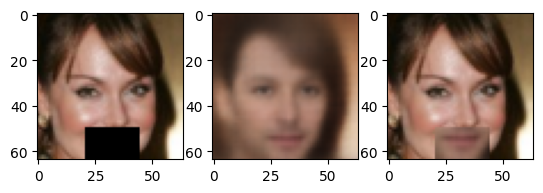

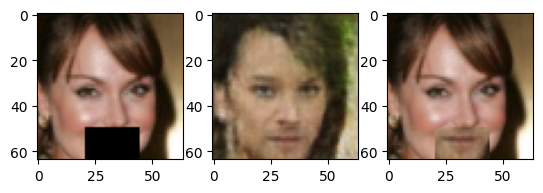

In [27]:
img_index = 8
label = 0

x1 = 50
y1 = 21
x2 = 65
y2 = 45
deletion = DeleteRectangle(x1,y1,x2-x1,y2-y1)
#deletion = DeleteRandomRectangle()

display_reconstruction(baseline, img_index, label, deletion)
display_reconstruction(fineTuned, img_index, label, deletion)